In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNEL=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Datasets/brain_tumor_dataset",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    shuffle=True
)

Found 253 files belonging to 2 classes.


In [4]:
for image_batch,batch_label in dataset.take(1):
  print(image_batch[0])
  print(image_batch[0].shape)
  print(batch_label[0])

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(256, 256, 3), dtype=float32)
(256, 256, 3)
tf.Tensor(1, shape=(), dtype=int32)


In [5]:
classes=dataset.class_names
classes

['no', 'yes']

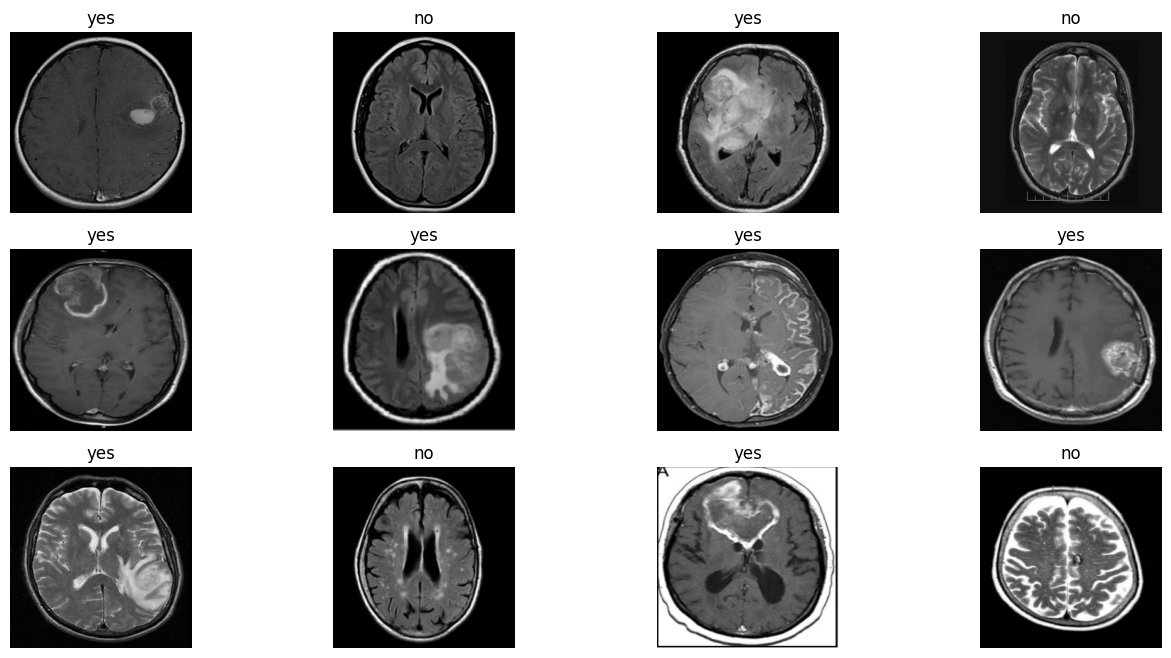

In [6]:
plt.figure(figsize=(16,8))
for image_batch,batch_label in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype(int))
    plt.title(classes[batch_label[i]])
    plt.axis("off")

In [7]:
#spliting the data into train,validation and test data
train_size=0.8
val_size=0.1
test_size=0.1

In [8]:
def get_data_separate(data,train_size,val_size,test_size):
  data_total_size=len(data)
  train_size=round(data_total_size*train_size)
  train_ds=data.take(train_size)
  remain_ds=data.skip(train_size)
  val_size=round(data_total_size*val_size)
  val_ds=remain_ds.take(val_size)
  test_ds=remain_ds.skip(val_size)
  return train_ds,val_ds,test_ds


In [9]:
train_ds,val_ds,test_ds=get_data_separate(dataset,train_size,val_size,test_size)

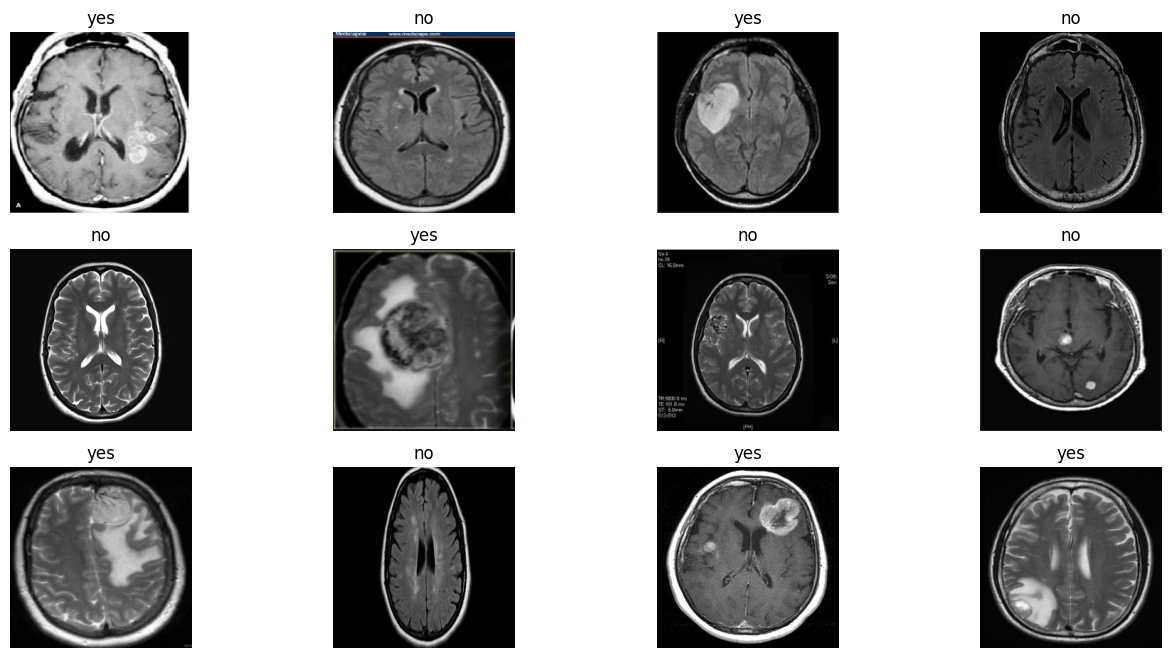

In [10]:
plt.figure(figsize=(16,8))
for image_batch,batch_label in train_ds.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype(int))
    plt.title(classes[batch_label[i]])
    plt.axis("off")

In [11]:
## skipping the time and complexcity using the chache and prefetch
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
## preprocessing of datset using the resize, resclaing and data augmentation
resize_and_rescale=tf.keras.Sequential([
    (layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE)),
    (layers.experimental.preprocessing.Rescaling(1.0/256))
])

In [13]:
data_augmentation=tf.keras.Sequential([
    (layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")),
    (layers.experimental.preprocessing.RandomRotation(0.2))
])

In [14]:
len(classes)

2

In [25]:
INPUT_SHAPE=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNEL)
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(len(classes),activation="softmax")
])
model.build(input_shape=INPUT_SHAPE)

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [27]:
## compilation of model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [28]:
history=model.fit(train_ds,
                  verbose=1,
                  epochs=100,
                  batch_size=BATCH_SIZE,
                  validation_data=val_ds)

Epoch 1/100
6/6 [==============================] - 3s 104ms/step - loss: 0.9885 - accuracy: 0.4531 - val_loss: 0.6947 - val_accuracy: 0.3750
Epoch 2/100
6/6 [==============================] - 0s 63ms/step - loss: 0.6914 - accuracy: 0.5000 - val_loss: 0.6912 - val_accuracy: 0.7500
Epoch 3/100
6/6 [==============================] - 0s 63ms/step - loss: 0.6909 - accuracy: 0.6354 - val_loss: 0.6884 - val_accuracy: 0.5312
Epoch 4/100
6/6 [==============================] - 0s 63ms/step - loss: 0.6782 - accuracy: 0.6719 - val_loss: 0.6809 - val_accuracy: 0.5312
Epoch 5/100
6/6 [==============================] - 0s 62ms/step - loss: 0.6748 - accuracy: 0.6719 - val_loss: 0.6750 - val_accuracy: 0.6562
Epoch 6/100
6/6 [==============================] - 0s 66ms/step - loss: 0.6643 - accuracy: 0.7240 - val_loss: 0.6560 - val_accuracy: 0.7812
Epoch 7/100
6/6 [==============================] - 0s 64ms/step - loss: 0.6585 - accuracy: 0.7083 - val_loss: 0.6477 - val_accuracy: 0.7812
Epoch 8/100
6/6 [==

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

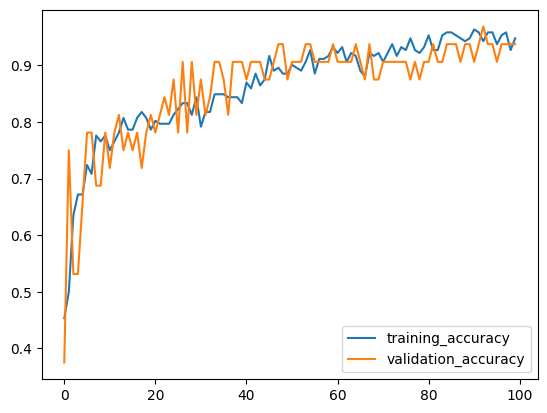

In [30]:
plt.plot(history.history["accuracy"],label="training_accuracy")
plt.plot(history.history["val_accuracy"],label="validation_accuracy")
plt.legend()

In [37]:
def prediction(model,image):
  img_array=tf.keras.preprocessing.image.img_to_array(image)
  img_array=tf.expand_dims(img_array,0)
  prediction=model.predict(img_array)
  pred=np.argmax(prediction)
  confidence=round(np.max(prediction)*100,2)
  return pred,confidence

1/1 [==============================] - 0s 20ms/step


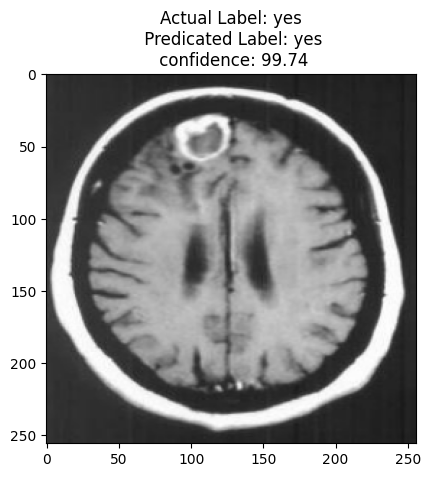

In [39]:
for image_batch,batch_label in test_ds.take(1):
  img=image_batch[0]
  label=batch_label[0]
  pred,confidence=prediction(model,img)
  plt.title(f"Actual Label: {classes[label]}\n Predicated Label: {classes[pred]}\n confidence: {confidence}")
  plt.imshow(img.numpy().astype(int))

1/1 [==============================] - 0s 18ms/step


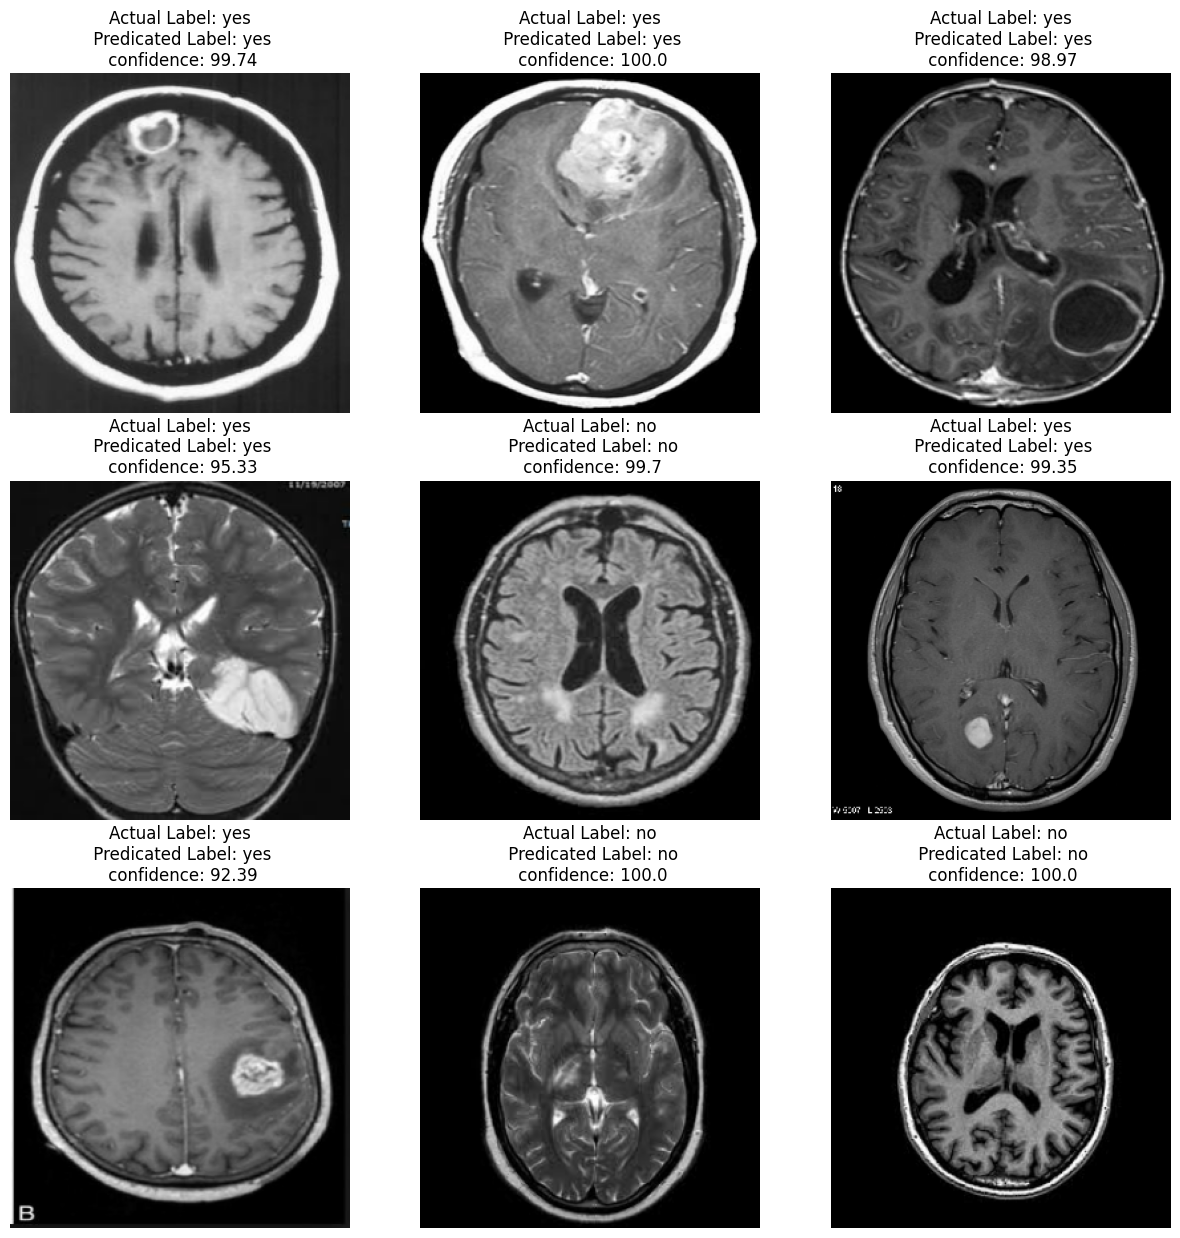

In [43]:
plt.figure(figsize=(15,15))
for image_batch,batch_label in test_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    img=image_batch[i]
    label=batch_label[i]
    pred,confidence=prediction(model,img)
    plt.title(f"Actual Label: {classes[label]}\n Predicated Label: {classes[pred]}\n confidence: {confidence}")
    plt.imshow(img.numpy().astype(int))
    plt.axis("off")

In [44]:
import os
print(os.getcwd())

/content
